In [17]:
# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

In [7]:
# [OLD] Code for classification

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/yu-hao/WindowsData/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [115]:
#[STAR] All the functions for reading the data for Wheat Dataset

from scipy import ndimage

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    r1 = [float(x) for x in r]
    r = r1
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df = pd.read_csv('/media/yu-hao/WindowsData/WheatDataset/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

temp = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
#train_df[['x', 'y', 'w', 'h']] = 
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = temp[:, 0]#train_df['x'].astype(np.float)
train_df['y'] = temp[:, 1]#train_df['y'].astype(np.float)
train_df['w'] = temp[:, 2]#train_df['w'].astype(np.float)
train_df['h'] = temp[:, 3]#train_df['h'].astype(np.float)

# df['bbox'] = df['bbox'].apply(lambda x: np.array(x))
# x = np.array(list(df['bbox']))
# print(x)
# for i, dim in enumerate(['x', 'y', 'w', 'h']):
#     df[dim] = x[:, i]

# # df.drop('bbox', axis=1, inplace=True)
# #df.head()

class WheatDatasetOld(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms = None):
        super().__init__()
        
        self.df = df
        self.image_ids  = self.df['image_id'].unique()
        self.image_dir  = Path(image_dir)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records  = self.df[self.df['image_id'] == image_id]
        
        im_name = image_id + '.jpg'
        img = Image.open(self.image_dir/im_name).convert("RGB")
        img = T.ToTensor()(img)
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #print('boxes shape is ',boxes.shape)
        boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        labels = torch.ones((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes']  = boxes
        target['labels'] = labels
        target['image_id']  = torch.tensor([idx])
        
        return img, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, transforms = None):
        super().__init__()
        
        self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')#.astype('float16')/60000.0
        self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')
        self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')
        self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')
        self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')
        self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')
        
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img = self.trainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        #print(img.shape, 'img shape is')
        #img = torch.Tensor(img).to(device)
        #img = T.ToTensor()(img).to(device)
        
        boxes = np.array([self.coordx[idx]/4, self.coordy[idx]/4, self.width_arr[idx]/4, self.height_arr[idx]/4])#records[['x', 'y', 'w', 'h']].values
        #print(boxes)
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #boxes = boxes
        #print('boxes shape is ',boxes.shape)
        #boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        #labels = torch.ones((1,), dtype=torch.int64)#torch.Tensor(self.trainy[idx]).to(device)
        
        area = self.width_arr[idx] * self.height_arr[idx]
        area = torch.Tensor(area)#.to(device)

        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)#.to(device)#torch.Tensor(np.array([1])).type(torch.int64).to(device)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)#.to(device)
        
        target = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [99]:
# [STAR] Wheat Dataset and Model Creation

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

print(valid_df.shape, train_df.shape)

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def collate_fn(batch):
    return tuple(zip(*batch))

DIR_INPUT = '/media/yu-hao/WindowsData/WheatDataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST  = f'{DIR_INPUT}/test'

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

(25006, 8) (122787, 8)


In [116]:
# [STAR] DBT Dataset and Model Creation

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset     = DBTDataset()
valid_dataset     = DBTDataset()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1, collate_fn=collate_fn
)



num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0001)
lr_scheduler = None

In [120]:
# [STAR] Training loop for DBT dataset

loss_hist = Averager()
itr = 1
num_epochs = 2000
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        #for img in images:
        #    print(img.shape)
        
        new_images  = []
        for img in images:
            #print(img.shape)
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.18050703406333923
Epoch #0 loss: 0.18265099371118204
Iteration #100 loss: 0.21059344708919525
Epoch #1 loss: 0.18232563297663415
Iteration #150 loss: 0.15630705654621124
Epoch #2 loss: 0.1812055672385863
Iteration #200 loss: 0.22794727981090546
Epoch #3 loss: 0.18008024644638812
Iteration #250 loss: 0.1493651270866394
Epoch #4 loss: 0.18040970633072512
Iteration #300 loss: 0.15332475304603577
Epoch #5 loss: 0.18039259420973913
Iteration #350 loss: 0.2143346071243286
Epoch #6 loss: 0.17975579760968685
Iteration #400 loss: 0.21658474206924438
Epoch #7 loss: 0.17894606199115515
Iteration #450 loss: 0.2005668431520462
Iteration #500 loss: 0.11410243064165115
Epoch #8 loss: 0.1788067196362785
Iteration #550 loss: 0.19684633612632751
Epoch #9 loss: 0.1783896815031767
Iteration #600 loss: 0.15466216206550598
Epoch #10 loss: 0.1780598262058837
Iteration #650 loss: 0.1681857854127884
Epoch #11 loss: 0.1772575197475297
Iteration #700 loss: 0.17196831107139587
Epoch #12 loss

Iteration #5650 loss: 0.15175358951091766
Epoch #100 loss: 0.13878399107073033
Iteration #5700 loss: 0.10538434982299805
Epoch #101 loss: 0.13895136463854993
Iteration #5750 loss: 0.1330810934305191
Epoch #102 loss: 0.13850957434624434
Iteration #5800 loss: 0.12407556921243668
Epoch #103 loss: 0.13775941090924398
Iteration #5850 loss: 0.12858472764492035
Epoch #104 loss: 0.13744035975209304
Iteration #5900 loss: 0.1452118456363678
Epoch #105 loss: 0.13728402076022966
Iteration #5950 loss: 0.15376465022563934
Epoch #106 loss: 0.13675155131412403
Iteration #6000 loss: 0.10248533636331558
Epoch #107 loss: 0.1363126350832837
Iteration #6050 loss: 0.1544152796268463
Iteration #6100 loss: 0.12190137058496475
Epoch #108 loss: 0.1363449865686042
Iteration #6150 loss: 0.13330937922000885
Epoch #109 loss: 0.1362410830333829
Iteration #6200 loss: 0.12407985329627991
Epoch #110 loss: 0.13549861032515764
Iteration #6250 loss: 0.12905293703079224
Epoch #111 loss: 0.13433460146188736
Iteration #6300 

Epoch #198 loss: 0.10762886689709765
Iteration #11150 loss: 0.1268461048603058
Iteration #11200 loss: 0.10969136655330658
Epoch #199 loss: 0.10667373173471008
Iteration #11250 loss: 0.09273150563240051
Epoch #200 loss: 0.10686399268784694
Iteration #11300 loss: 0.10979817062616348
Epoch #201 loss: 0.10627509094774723
Iteration #11350 loss: 0.09261061996221542
Epoch #202 loss: 0.10628156270831823
Iteration #11400 loss: 0.12525777518749237
Epoch #203 loss: 0.10552472528070211
Iteration #11450 loss: 0.10788298398256302
Epoch #204 loss: 0.10454759547220809
Iteration #11500 loss: 0.11233296990394592
Epoch #205 loss: 0.105720529332757
Iteration #11550 loss: 0.08608479052782059
Epoch #206 loss: 0.10494013529803072
Iteration #11600 loss: 0.09216652065515518
Epoch #207 loss: 0.10461249694760356
Iteration #11650 loss: 0.07759207487106323
Iteration #11700 loss: 0.0792614221572876
Epoch #208 loss: 0.10456703137606382
Iteration #11750 loss: 0.1228722333908081
Epoch #209 loss: 0.10420131058033023
It

Iteration #16550 loss: 0.09648824483156204
Epoch #295 loss: 0.08363536552393011
Iteration #16600 loss: 0.06752922385931015
Epoch #296 loss: 0.08414590525041733
Iteration #16650 loss: 0.09731148928403854
Epoch #297 loss: 0.08367971929588489
Iteration #16700 loss: 0.1161753311753273
Epoch #298 loss: 0.08355343082387533
Iteration #16750 loss: 0.09671682864427567
Iteration #16800 loss: 0.09605369716882706
Epoch #299 loss: 0.08393869243030037
Iteration #16850 loss: 0.09844731539487839
Epoch #300 loss: 0.08318476052954793
Iteration #16900 loss: 0.0733928233385086
Epoch #301 loss: 0.08309833924951297
Iteration #16950 loss: 0.08921081572771072
Epoch #302 loss: 0.08279333955475263
Iteration #17000 loss: 0.07769815623760223
Epoch #303 loss: 0.0823241518145161
Iteration #17050 loss: 0.06953901052474976
Epoch #304 loss: 0.08221232611685991
Iteration #17100 loss: 0.07228341698646545
Epoch #305 loss: 0.08176550109471593
Iteration #17150 loss: 0.08339197933673859
Epoch #306 loss: 0.0821416298193591
I

KeyboardInterrupt: 

In [121]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [128]:
print(outputs[0])

{'boxes': tensor([[146.1737, 274.2574, 240.9250, 380.4249],
        [165.3364, 285.8174, 219.7844, 367.9336],
        [131.4510, 241.8974, 252.8674, 420.4388],
        [171.3982, 307.0421, 211.0134, 341.4581],
        [164.6465, 304.9130, 257.1588, 409.9449]], grad_fn=<CopyBackwards>), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([0.9240, 0.5355, 0.4014, 0.0988, 0.0611], grad_fn=<CopyBackwards>)}


In [133]:
temp = outputs[0]['boxes'].data.cpu().numpy()
print(temp[0])

[146.17372 274.25745 240.92505 380.42487]


torch.Size([3, 750, 500])


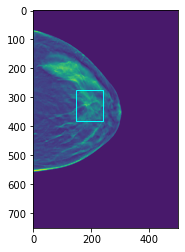

In [135]:
#print(outputs)
import matplotlib.patches as patches

print(images[0].shape)
plt.imshow(images[0][0].data.cpu().numpy())
ax   = plt.gca()

index = 0
rect = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
#rect = patches.Rectangle((temp[index][1], temp[index][0]), temp[index][3]-temp[index][1], temp[index][2]-temp[index][0], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)
#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images  = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes  = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
# [STAR] For plotting the images

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [15]:
loss_hist = Averager()
itr = 1
num_epochs = 200
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(len(images), len(targets), images[0].shape, len(targets[0]['boxes']))
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 1.7607202701618698
Iteration #100 loss: 1.7268396514227657
Iteration #150 loss: 1.7064545852167243
Iteration #200 loss: 2.0347349650472
Iteration #250 loss: 1.712778722073257
Iteration #300 loss: 1.5943888343150856
Iteration #350 loss: 1.5178248758969637
Iteration #400 loss: 1.5444363160208001
Iteration #450 loss: 1.5647550482854071
Iteration #500 loss: 1.5485437903163515
Iteration #550 loss: 1.9103887034181755
Iteration #600 loss: 1.491785500489904
Iteration #650 loss: 1.466433896319538
Epoch #0 loss: 1.7162335509320108
Iteration #700 loss: 1.7310519640009574
Iteration #750 loss: 1.4555127588148413
Iteration #800 loss: 1.4856642979590085
Iteration #850 loss: 2.133777053700693
Iteration #900 loss: 1.6277719320275719
Iteration #950 loss: 1.44726940291462
Iteration #1000 loss: 1.3971989617046594
Iteration #1050 loss: 1.3552668006526838
Iteration #1100 loss: 1.375852235221211
Iteration #1150 loss: 1.3284461516759858
Iteration #1200 loss: 1.3081550448389287
Iteration #1

KeyboardInterrupt: 

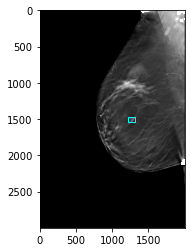

In [24]:
# [STAR] DBT Training Code

import matplotlib.patches as patches
import random

from torchvision import  transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from PIL import Image

index = random.randint(0, len(td1)-1)
a, b, c = td1[index]
temp  = b['boxes'].data.cpu().numpy()
index = random.randint(0, len(temp)-1)

#print(temp)

im    = a.data.cpu().numpy()
plt.imshow(im[0].astype('float32'), cmap='gray')

ax   = plt.gca()


index = 0
rect = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
#rect = patches.Rectangle((temp[index][1], temp[index][0]), temp[index][3]-temp[index][1], temp[index][2]-temp[index][0], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)
#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)


plt.show()

In [138]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = DBTDataset()
#valid_dataset = DBTDataset()


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

# valid_data_loader = DataLoader(
#     valid_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=4,
#     collate_fn=collate_fn
# )

In [143]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

num_classes = 2

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.5)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20

In [145]:
num_epochs = 2000

loss_hist = Averager()
itr = 1
#train_dataset = td1
#model.train()
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for k in range(len(train_dataset)-1):
        images, targets, image_ids = train_dataset[k]
        #for images, targets, image_ids in train_data_loader:
        #print(images, targets)
        
        images  = [images]
        targets = [targets]
        #images  = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        loss_dict = model(images, targets)
        
        #losses = loss_dict['loss_rpn_box_reg'] + loss_dict['loss_objectness']
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(loss_dict)
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration #50 loss: nan
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7726, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration #100 loss: nan
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7703, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad

KeyboardInterrupt: 

In [121]:
print(targets)

[{'boxes': tensor([[  76., 1665.,  254., 1791.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([156]), 'area': tensor([22428.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]


In [107]:
model.eval()

images, targets, image_ids = train_dataset[k]
images  = [images]
targets = [targets]

loss_dict = model(images)
        

In [106]:
model.eval()
images  = [images]
#cpu_device = torch.device("cpu")
outputs = model(images)
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

AttributeError: 'list' object has no attribute 'shape'

In [110]:
print(loss_dict[0]['boxes'])

tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>)


In [101]:
print(images[0].shape)

torch.Size([1, 3000, 2000])


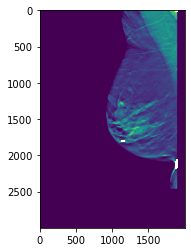

In [103]:
plt.imshow(images[0][0].cpu())